# System MTF Budget: Satellite Example

## Introduction

The Modulation Transfer Function (MTF) essentially describes the ability of an optical system to resolve fine detail. However, the system MTF is not limited to optics or the detector. Anything impacting the MTF (or, in practical terms blurring or smearing the image) should be accounted for. The final system MTF is a combination of all such factors.

In this example we will compute a sample MTF budget for the French high-res satellite Pléiades.

Sources for the Pléiades data:

- [ESA Pléiades page](https://earth.esa.int/eogateway/missions/pleiades#instruments-section)
- [eoPortal Pléiades page](https://www.eoportal.org/satellite-missions/pleiades#hiri-high-resolution-imager)

## Loading the Imager Parameters

We have to start with the opticks package import (as the notebook sometimes fails to find it).

An imager is made up of three parts: Optics, Detector and (optionally) Read-out/Write Electronics. We load the configuration files for each part and initialise the `Imager` object.

In [3]:
# If opticks import fails, try to locate the module
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

In [4]:
from pathlib import Path

from opticks.imager_model.detector import Channel
from opticks.imager_model.imager import Imager

print(f"current working directory: {Path.cwd()}")

file_directory = Path("docs", "examples", "sample_sat_pushbroom")
optics_file_path = file_directory.joinpath("optics.yaml")
detector_file_path = file_directory.joinpath("pan_detector.yaml")
rw_electronics_file_path = file_directory.joinpath("rw_electronics.yaml")

# check whether input files exist
print(
    f"optics file:  [{optics_file_path}] (file exists:  {optics_file_path.is_file()})"
)
print(
    f"detector file exists:  [{detector_file_path}] (file exists:  {detector_file_path.is_file()})"
)
print(
    f"RW electronics file exists:  [{rw_electronics_file_path}] (file exists:  {rw_electronics_file_path.is_file()})"
)

# Init imager object
imager = Imager.from_yaml_file(
    optics_file_path, detector_file_path, rw_electronics_file_path
)

# shorthands
optics = imager.optics
detector = imager.detector
rw_electronics = imager.rw_electronics

# select the PAN channel
band_id = "pan"
channel: Channel = detector.params.channels.all[band_id]


current working directory: /home/egemen/Projects/opticks
optics file:  [docs/examples/sample_sat_pushbroom/optics.yaml] (file exists:  True)
detector file exists:  [docs/examples/sample_sat_pushbroom/pan_detector.yaml] (file exists:  True)
RW electronics file exists:  [docs/examples/sample_sat_pushbroom/rw_electronics.yaml] (file exists:  True)


## Imager MTF

The imager comprises the optics and the detector. The optics and detector MTFs can be plotted for the increasing input line frequencies. Usually the optics MTF comes out of Zemax computations or lab measurements. 

Each of these is MTF components is encapsulated in an `MTF_Model` object. The object can be queried for `mtf_value()` for an input line frequency. In this example we will use the ideal optical MTF (given by the `MTF_Model.ideal_optics()` default model). We will then evaluate it for 100 intermediate line frequencies, all the way to the spatial cutoff frequency, where (by definition) no more detail can be resolved by the optics. Similar to the Optical MTF, the Detector MTF will be calculated via the `MTF_Model.detector_sampling()` function. On the other hand, the detector Nyquist frequency determines the maximum theoretical resolution that can be obtained from the imager.

It should be taken into account that the spatial cutoff frequency is also a function of the wavelength and Pléiades PAN works in the range 480 to 820 nm.

Note the widely used bands:

- blue: 450-485 nm
- green: 500-565 nm
- red: 625-750 nm
- nir: 780-2500 nm

In this example we will evaluate the Optics MTF at the limits as well as the middle of the PAN range. Then we will compute the Detector MTF and finally we will combine the 650 nm Optics MTF with the Detector MTF to obtain the Imager MTF (at 650 nm).

First we investigate the wavelength dependency of the MTF. For that we mark three wavelengths, the two extremes of Pléiades PAN range and the middle: 480 nm, 650 nm and 820 nm.

We will also plot the Detector Nyquist Limit to illustrate the bounds of the useful MTF.

In [5]:
from opticks import u

import numpy as np
from opticks.perf_model.mtf import MTF_Model

ref_wavelength = [480, 650, 820] * u.nm

# Generate the optics MTF data for the wavelengths
cutoff_freq = optics.spatial_cutoff_freq(ref_wavelength)
line_freq_unit = cutoff_freq.u
input_line_freq = np.linspace(0.0, cutoff_freq.m, 100) * line_freq_unit

mtf_ideal_opt_rng = MTF_Model.ideal_optics(ref_wavelength, optics)
optical_mtf_values = mtf_ideal_opt_rng.mtf_value(input_line_freq)

# Generate the detector Nyquist limit
nyq_freq = channel.nyquist_freq(with_binning=True)

Now that we have generated the data points, we can create the optical MTF plot.

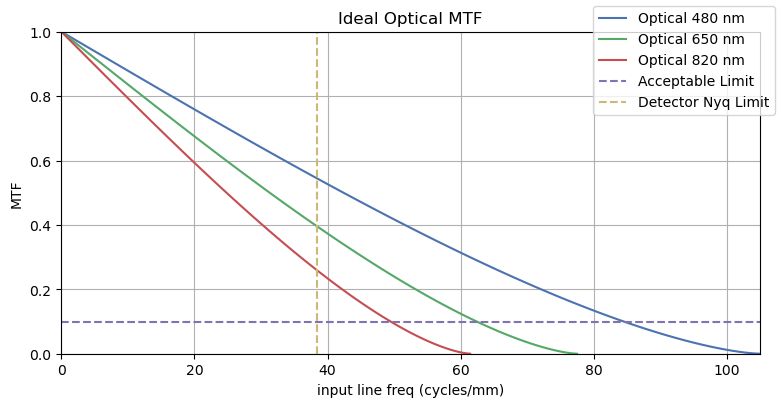

In [6]:
from matplotlib import pyplot as plt

from opticks.perf_model.mtf import set_mtf_plot_style

%matplotlib inline

# pint support to matplotlib
u.setup_matplotlib()

# set plot style
plt.style.use("seaborn-v0_8-deep")

# plot the MTF data
# -----------------
fig, ax = plt.subplots()

# Optical MTF data
ax.plot(
    input_line_freq,
    optical_mtf_values,
    label=[
        f"Optical {ref_wavelength[0]:~P}",
        f"Optical {ref_wavelength[1]:~P}",
        f"Optical {ref_wavelength[2]:~P}",
    ],
)

# acceptable limit
ax.plot(
    [0.0, input_line_freq.max().m],
    [0.1, 0.1],
    label="Acceptable Limit",
    linestyle="--",
)

# detector Nyquist limit
ax.plot(
    [nyq_freq.m, nyq_freq.m],
    [0.0, 1.0],
    label="Detector Nyq Limit",
    linestyle="--",
)

# set MTF plot style tweaks
set_mtf_plot_style(fig, ax, x_max= cutoff_freq.max(), title="Ideal Optical MTF",)

# plot the figure
plt.show()

From the plot, certain observations can be made:
- As the PAN band has a very broad frequency range, the incoming light wavelength impacts the MTF performance very significantly. At the blue limit of the band (480 nm), detail is resolved significantly better than the red in the middle of the band (650 nm) and the near-infrared limit at the end (820 nm).
- The pixel size limits the MTF (Nyquist limit) and does not allow input line frequencies above approximately 38 line pairs/mm, even though the optics can resolve detail for higher input line frequencies.
- While not a hard rule, an System MTF of 0.1 at the Nyquist Limit is desired. This ensures that the fine detail in the scene is resolved at an adequate sharpness. In this example, the Imager MTF (at 650 nm) is around 0.25. This is a good value, but it should be kept in mind that the optics are assumed ideal and the computed value can be called the "Static MTF". On the satellite, it will be subject to other effects due to several sources of motion, degrading the image quality further.

While this is the ideal optical MTF, in reality aberrations would introduce a degradation. For a satellite like Pléiades, a Wavefront Error ($W_{RMS}$) of 5% of the wavelength is a reasonable first guess. This can be used to generate an approximate aberrated optical MTF. That said, the central obstruction due to the secondary mirror is not taken into account and could in reality be significant.

For the remainder of the computations we will focus on the midrange wavelength (650 nm).

In [7]:
# Select midrange wavelength
ref_wavelength_mid = channel.centre_freq
cutoff_freq_mid = optics.spatial_cutoff_freq(ref_wavelength_mid)
input_line_freq_mid = np.linspace(0.0, cutoff_freq_mid.m, 100) * cutoff_freq_mid.u


# Generate the midrange ideal optical MTF model and values
mtf_ideal_opt_mid = MTF_Model.ideal_optics(ref_wavelength_mid, optics)
optical_mtf_mid_values = mtf_ideal_opt_mid.mtf_value(input_line_freq_mid)

# Generate the midrange aberrated optical MTF model and values
w_rms = 0.05
mtf_aberr_opt_mid = MTF_Model.aberrated_optics(ref_wavelength_mid, w_rms, optics)
aberr_opt_mtf_mid_values = mtf_aberr_opt_mid.mtf_value(input_line_freq_mid)

# Generate the detector MTF data (use 650 nm input line data)
pixel_pitch = channel.pixel_pitch(with_binning=True)
mtf_det_sampling_model = MTF_Model.detector_sampling(pixel_pitch)
detector_mtf = mtf_det_sampling_model.mtf_value(input_line_freq_mid)

# Generate the imager MTF data at 650 nm (imager = aberrated optics x detector)
imager_mtf = aberr_opt_mtf_mid_values * detector_mtf


The data has been generated for the ideal optical MTF, aberrated optical MTF and the detector MTF, as well as the combined imager MTF, which uses the aberrated optics model.

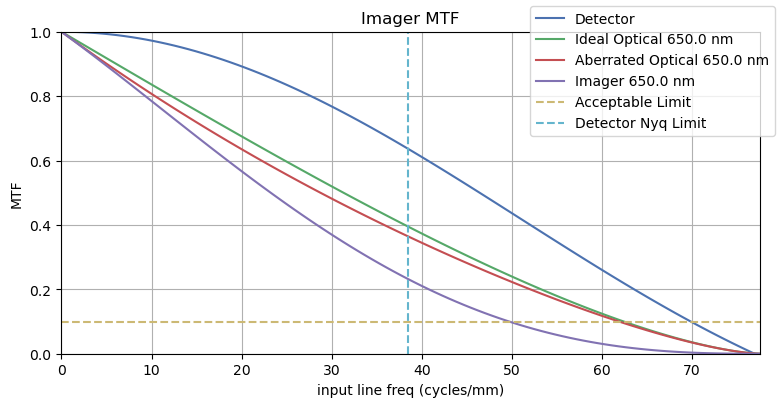

In [8]:
# plot the MTF data
# -----------------
fig, ax = plt.subplots()

# detector MTF
ax.plot(input_line_freq_mid, detector_mtf, label="Detector")

# Ideal Optical MTF
ax.plot(
    input_line_freq_mid,
    optical_mtf_mid_values,
    label=f"Ideal Optical {ref_wavelength_mid:~P}",
)

# Aberrated Optical MTF
ax.plot(
    input_line_freq_mid,
    aberr_opt_mtf_mid_values,
    label=f"Aberrated Optical {ref_wavelength_mid:~P}",
)

# total imager MTF
ax.plot(
    input_line_freq_mid,
    imager_mtf,
    label=f"Imager {ref_wavelength_mid:~P}",
)

# acceptable limit
ax.plot(
    [0.0, input_line_freq.max().m],
    [0.1, 0.1],
    label="Acceptable Limit",
    linestyle="--",
)

# detector Nyquist limit
ax.plot(
    [nyq_freq.m, nyq_freq.m],
    [0.0, 1.0],
    label="Detector Nyq Limit",
    linestyle="--",
)

# set MTF plot style tweaks
set_mtf_plot_style(fig, ax, x_max=input_line_freq_mid.max(), title="Imager MTF")


# plot the figure
plt.show()

The first observation from the plot is that, at this small wavefront error, aberrations don't change Ideal Optics MTF significantly. On the other hand, the total Imager MTF is much lower than the pure Optical MTF, decreasing to about 0.25 at the detector Nyquist limit. Nevertheless, it is still above the acceptable limit. This is sometimes called the "Static MTF", because it is the theoretical MTF of the instrument at the lab conditions (assuming there are no vibration sources inside, such as a cryocooler). We will investigate the "Dynamic MTF" in the next section, where the motion of the camera introduces blurring and smearing.

Finally, another (fairly) useful metric is the Optical Q value. Particularly for this broad PAN band, it should be computed for different wavelengths to assess the overall quality.

In [9]:
# compute Q (for the three wavelengths)
q = imager.q_factor(ref_wavelength, band_id, with_binning=True)

print(f"Optical Q : {np.array_str(q.m, precision=5)}")

Optical Q : [0.73307 0.99269 1.25232]
Optical Q : [0.73307 0.99269 1.25232]


When the Optical Q value can be computed for the three reference wavelengths (the limits and the middle of PAN), it can be observed that the middle 650 nm has a Q value that is practically equal to 1 and even the 820 nm edge wavelength has a Q value of 1.25.

## Dynamic MTF

Dynamic MTF is the broad name given to multiple sources of image sharpness loss, commonly due to a "shaking" of the imager or a relative motion between the imager and the platform. Depending on the problem, one or more of the following sources can be present:


Due to imager shake (platform or internal like crycooler), motion blur

*** does not include other effects like atmosphere but they should be included for E2E MTF***
